# Visualise BCM data
3rd October 2024

In [39]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cartopy.feature as cf
import cartopy.crs as ccrs

import sys
sys.path.append('/Users/kenzatazi/Documents/CDT/Code/')
sys.path.append('/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/')
from cartopy.io import shapereader
from shapely.geometry import LinearRing
import matplotlib.patheffects as pe

In [4]:
%load_ext autoreload
%autoreload 2

In [8]:
df = pd.read_csv('/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/bcm_outputs/historical/bcm_historical_CSIRO_RegCM4_1951_2005.csv')
lmbda = np.load('/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/bcm_outputs/historical/lambda_historical_CSIRO_RegCM4_1951_2005.npy')

In [9]:
df

,lat,lon,month,mean,mean_uvar,var_log,var,var_log_uvar
0,20.125,60.125,1.0,-1.651280,0.004883,-1.350960,0.258992,0.019418
1,20.125,60.375,1.0,-1.696520,0.003111,-1.379872,0.251611,0.013539
2,20.125,60.625,1.0,-1.737212,0.003040,-1.403659,0.245696,0.013082
3,20.125,60.875,1.0,-1.777112,0.003019,-1.420329,0.241634,0.013020
4,20.125,61.125,1.0,-1.817678,0.003013,-1.429713,0.239378,0.013001
...,...,...,...,...,...,...,...,...
172795,39.875,103.875,12.0,-0.818519,0.003013,-2.818464,0.059698,0.013001
172796,39.875,104.125,12.0,-0.835386,0.003019,-2.930855,0.053351,0.013020
172797,39.875,104.375,12.0,-0.850020,0.003040,-3.012150,0.049186,0.013082
172798,39.875,104.625,12.0,-0.854392,0.003111,-3.060958,0.046843,0.013539


In [10]:
df['mean_tr'] = sp.special.inv_boxcox(df['mean'].values, lmbda)
u95 = sp.special.inv_boxcox(df['mean'].values + 1.645 * np.sqrt(np.abs(df['var'])), lmbda)
l95 = sp.special.inv_boxcox(df['mean'].values - 1.645 * np.sqrt(np.abs(df['var'])), lmbda)
l95 = np.nan_to_num(l95, nan=0)
df['p95'] = u95 
df['p5']=  l95
df1 = df.set_index(['month', 'lat', 'lon'])
ds = xr.Dataset.from_dataframe(df1[['mean_tr', 'p95', 'p5']])

In [11]:
proj = ccrs.PlateCarree()
ocean_50m = cf.NaturalEarthFeature(
        "physical", "ocean", "50m", edgecolor="darkgrey", facecolor='white')

In [12]:
# HKH region
hkh_region_path = data_dir + "Shapefiles/hkh/outline.shp"
hkh_region_shape = shapereader.Reader(hkh_region_path)
hkh_region_globe = ccrs.Globe(semimajor_axis=6377276.345, inverse_flattening=300.8017)
hkh_region = ccrs.PlateCarree()

In [16]:
def regional_rectangle(lonmin, lonmax, latmin, latmax, nvert=100):
    """ Return Polygon object to create regional rectangle on maps."""
    lons = np.r_[
        np.linspace(lonmin, lonmin, nvert),
        np.linspace(lonmin, lonmax, nvert),
        np.linspace(lonmax, lonmax, nvert),
    ].tolist()

    lats = np.r_[
        np.linspace(latmin, latmax, nvert),
        np.linspace(latmax, latmax, nvert),
        np.linspace(latmax, latmin, nvert),
    ].tolist()

    pgon = LinearRing(list(zip(lons, lats)))

    return pgon

In [36]:
hma1 = regional_rectangle(71, 79, 32, 39)
hma2 = regional_rectangle(76, 93, 27, 32)
hma3 = regional_rectangle(93, 103, 28, 36)
region_dict2 = {'HMA1': [71.5, 37.5], 'HMA2': [76.5, 30.5], 'HMA3': [93.5, 34.5],}   

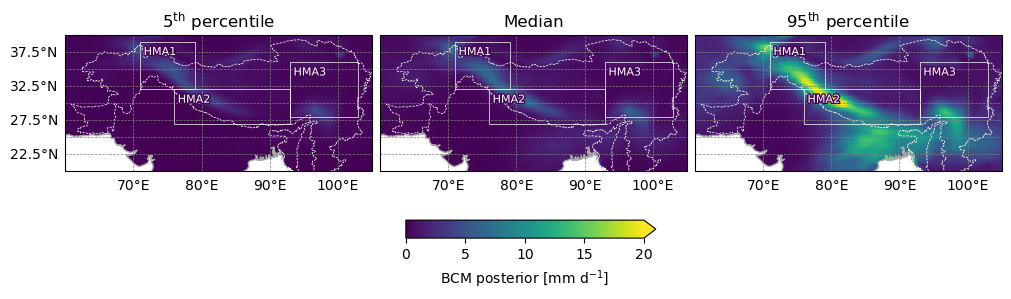

In [37]:
m = 1

fig, ax = plt.subplots(1, 3, figsize=(10, 3), subplot_kw={'projection': ccrs.PlateCarree()}, layout="constrained")

# Mean facet grid plot
mean_fg = ds.isel(month=m).mean_tr.plot(x="lon", y="lat", ax=ax[1], vmin=0, vmax=20, 
                                        add_colorbar=False, linewidth=0, rasterized=True)
gl0 = ax[1].gridlines(draw_labels=True, linewidth=0.5, linestyle='--', color='gray')
gl0.top_labels = False
gl0.right_labels = False
gl0.left_labels = False
ax[1].set_title('Median')
ax[1].add_feature(ocean_50m)

# CI95 facet grid plot
p95= ds.isel(month=m).p95.plot(x="lon", y="lat", ax=ax[2], vmin=0, vmax=15, 
                               add_colorbar=False, linewidth=0, rasterized=True)
gl0 = ax[2].gridlines(draw_labels=True, linewidth=0.5, linestyle='--', color='gray')
gl0.top_labels = False
gl0.right_labels = False
gl0.left_labels = False
ax[2].set_title('95$^\mathrm{th}$ percentile')
ax[2].add_feature(ocean_50m)

p5= ds.isel(month=m).p5.plot(x="lon", y="lat", ax=ax[0], vmin=0, vmax=15, 
                             add_colorbar=False, linewidth=0, rasterized=True)                    
gl0 = ax[0].gridlines(draw_labels=True, linewidth=0.5, linestyle='--', color='gray')
gl0.top_labels = False
gl0.right_labels = False
ax[0].set_title('5$^\mathrm{th}$ percentile')
ax[0].add_feature(ocean_50m)


cax = fig.add_axes([0.40, 0.05, 0.25, 0.06])
cbar= fig.colorbar(mean_fg, cax=cax, orientation='horizontal', extend='max')
cbar.set_label("BCM posterior [mm d$^{-1}$]")

for i in range(3):
    ax[i].add_geometries([hma1, hma2, hma3], proj, edgecolor="white",
            facecolor="None", linestyle='-', linewidth=0.5)
    for rec in hkh_region_shape.records():
        ax[i].add_geometries(
            [rec.geometry],
            hkh_region,
            edgecolor="white",
            facecolor="None",
            linestyle='--',
            linewidth=0.5)
    for region, coord in region_dict2.items():
        ax[i].text(coord[0], coord[1], region, fontsize=8, color='white', ha='left', va='center', zorder=10, 
            path_effects=[pe.withStroke(linewidth=2,  foreground="#440154")])

plt.savefig('CSIRO_1951_2005_02.pdf', bbox_inches='tight')
plt.show()
